# Prescriptor Experiments
#### This notebook is to replicate the process used in [Discovering Effective Policies for Land-Use Planning](https://doi.org/10.48550/arXiv.2311.12304)

In [1]:
import json
import os
from pathlib import Path

from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

from data import constants
from data.eluc_data import ELUCData
from prescriptors.prescriptor import UnileafPrescriptor, reco_to_context_actions
from predictors.neural_network.neural_net_predictor import NeuralNetPredictor

In [2]:
dataset = ELUCData()

### Load Results

In [3]:
experiment_results_dir = Path("prescriptors/trained_prescriptors/no-overlap/seeded")
stats_file = experiment_results_dir / "experiment_stats.csv"
with open(stats_file) as csv_file:
    stats_df = pd.read_csv(csv_file, sep=',')
last_gen_filename = os.path.join(experiment_results_dir, str(len(stats_df)) + '.csv')
last_gen_df = pd.read_csv(last_gen_filename)
pareto_df = last_gen_df[last_gen_df['NSGA-II_rank'] == 1]
# Sort by first objective, maximize: lowest to highest, minimize: highest to lowest
pareto_df = pareto_df.sort_values(by='change', ascending=True)

### Figure Save Dir

In [4]:
figure_dir = Path("experiments/figures/no-overlap")
figure_dir.mkdir(parents=True, exist_ok=True)

## Generation Plotting

In [5]:
def get_pareto_df(dir, gen):
    """
    Gets the pareto df for a given generation.
    :param dir: The experiment results directory.
    :param gen: The generation to get the pareto df for.
    """
    gen_filename = os.path.join(dir, f"{gen}.csv")
    gen_df = pd.read_csv(gen_filename)
    gen_pareto_df = gen_df[gen_df['NSGA-II_rank'] == 1]
    # Sort by first objective, maximize: lowest to highest, minimize: highest to lowest
    gen_pareto_df = gen_pareto_df.sort_values(by='change', ascending=True)
    gen_pareto_df["Name"] = f"Gen {gen}"
    return gen_pareto_df

def get_merged_df(dir, gens):
    """
    Gets the pareto df for multiple generations and merges them into one.
    :param dir: The experiment results directory.
    :param gens: List of generations to get the pareto df for.
    """
    dfs = []
    for gen in gens:
        dfs.append(get_pareto_df(dir, gen))
    merged_df = pd.concat(dfs, ignore_index=True)
    return merged_df

def get_overall_pareto_df(final_gen):
    pareto_list = []
    # First, go through each gen and add prescriptors that aren't already dominated.
    for gen in range(1, final_gen + 1):
        gen_filename = os.path.join(experiment_results_dir, f"{gen}.csv")        
        gen_df = pd.read_csv(gen_filename)
        gen_pareto_df = gen_df[gen_df['NSGA-II_rank'] == 1]
        for idx, row in gen_pareto_df.iterrows():
            pareto = True
            for p in pareto_list:
                # if (((p['ELUC'] < row['ELUC']) and (p['change'] <= row['change'])) or \
                #     ((p['ELUC'] <= row['ELUC']) and (p['change'] < row['change'])) or \
                #     ((p['ELUC'] == row['ELUC']) and (p['change'] == row['change']))):
                if p['ELUC'] <= row['ELUC'] and p['change'] <= row['change']:
                    pareto = False
                    break
            if pareto:
                pareto_list.append(row)

    # Go through the results and remove prescriptors that got dominated by later ones.
    filtered_pareto_list = []
    for i in range(len(pareto_list)):
        row = pareto_list[i]
        pareto = True
        for j in range(i+1, len(pareto_list)):
            p = pareto_list[j]
            # if (((p['ELUC'] < row['ELUC']) and (p['change'] <= row['change'])) or \
            #     ((p['ELUC'] <= row['ELUC']) and (p['change'] < row['change'])) or \
            #     ((p['ELUC'] == row['ELUC']) and (p['change'] == row['change']))):
            if p['ELUC'] <= row['ELUC'] and p['change'] <= row['change']:
                pareto = False
                break
        if pareto:
            filtered_pareto_list.append(row)

    return pd.DataFrame(filtered_pareto_list)


def plot_gens(dir, gens, save_path=None):
    """
    Plots the pareto front for multiple generations.
    :param dir: The experiment results directory.
    :param gens: List of generations to plot the pareto front for.
    """
    merged_df = get_merged_df(dir, gens)
    fig, ax = plt.subplots()
    cmap = plt.get_cmap("tab10")
    colors = [cmap(i) for i in [0, 1, 2, 5, 4]]
    curve_names = []
    for i, gen in enumerate(gens):
        curve_name = f"Gen {gen}"
        curve_names.append(curve_name)

        merged_df[merged_df["Name"] == curve_name].plot(x='change',
                       y='ELUC',
                       marker='o',
                       ylabel='ELUC',
                       ax=ax,
                       color=colors[i],
                       label="Gen " + str(gen))

    overall_pareto_df = get_overall_pareto_df(gens[-1])
    overall_pareto_df = overall_pareto_df.sort_values(by="change")
    overall_pareto_df.plot(x='change', y='ELUC', c='r', marker='o', ax=ax, label="Final Pareto Front")
    #plt.xlim(0, 0.4)
    plt.grid() 
    # handles, labels = plt.gca().get_legend_handles_labels()
    # order = [0, 1, 2, 4, 3]
    # plt.legend([handles[idx] for idx in order], [curve_names[idx] for idx in order], loc="upper right")
    plt.legend(prop={'size': 9})
    #plt.title("Pareto Fronts Across Generations")
    if save_path:
        plt.savefig(save_path, format="png", dpi=300)
    plt.show()

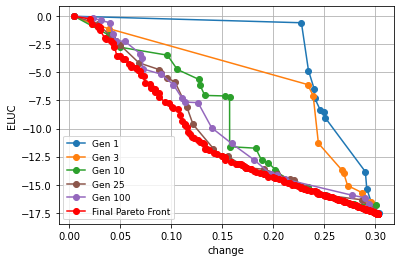

In [46]:
plot_gens(experiment_results_dir, [1, 3, 10, 25, 100], save_path=figure_dir / "pareto.png")

In [7]:
def get_gen_df(gen):
    gen_filename = os.path.join(experiment_results_dir, f"{gen}.csv")
    gen_df = pd.read_csv(gen_filename)
    # Sort by first objective, maximize: lowest to highest, minimize: highest to lowest
    gen_df = gen_df.sort_values(by='change', ascending=True)
    gen_df["Name"] = f"Gen {gen}"
    return gen_df

def get_all_gens_df(gens):
    dfs = []
    for gen in gens:
        dfs.append(get_gen_df(gen))
    merged_df = pd.concat(dfs, ignore_index=True)
    return merged_df

In [10]:
def plot_all_gens(dir, gens, save_path=None):
    all_gens_df = get_all_gens_df(gens)
    fig, ax = plt.subplots()

    all_gens_df.plot.scatter(x='change',
                             y='ELUC',
                             ax=ax,
                             label="All prescriptors evaluated")
    # Plot last gen's pareto front in red
    
    #get_pareto_df(dir, gens[-1]).plot.scatter(x='change', y='ELUC', c='red', ax=ax, label="Gen 100 Pareto Front")
    overall_pareto = get_overall_pareto_df(gens[-1])
    overall_pareto.plot.scatter(x='change', y='ELUC', c='red', ax=ax, label="Final Pareto Front")
    plt.grid()
    #plt.title("All Generations All Prescriptor Performance")
    plt.legend(loc="upper left")
    if save_path:
        plt.savefig(save_path, format="png", dpi=300) 
    plt.show()

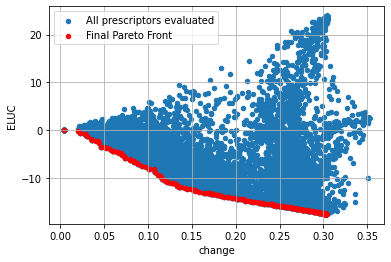

In [45]:
plot_all_gens(experiment_results_dir, [a + 1 for a in range(100)], save_path=figure_dir/"nn-global-allprescriptors.png")

In [12]:
all_gen_pareto_df = get_overall_pareto_df(len(stats_df))

## Heuristic Pareto

In [13]:
def perfect_prescribe_row(row, reco_coefs, pct_change):
    # Weird case where row is all zeroes
    if row[constants.LAND_USE_COLS].sum() == 0:
        return row
    scaled_change = pct_change * row[constants.LAND_USE_COLS].sum()
    best_col = reco_coefs[-1][0]
    max_change = min(row[constants.RECO_COLS].sum() - row[best_col], scaled_change)
    changed = 0
    for coef in reco_coefs:
        if not coef[0] == best_col: # This technically shouldn't be necessary
            # If we have more change left than there is in this column, delete it all
            if row[coef[0]] < max_change - changed:
                changed += row[coef[0]]
                row[coef[0]] = 0
            # Otherwise, remove however much change is left
            else:
                row[coef[0]] -= (max_change - changed)
                changed = max_change
                break
    row[best_col] += changed
    return row


def even_prescribe_row(row, pct_change, best_col):
    # Weird case where row is all zeroes
    if row[constants.LAND_USE_COLS].sum() == 0:
        return row
    scaled_change = pct_change * row[constants.LAND_USE_COLS].sum()
    presc_cols = [col for col in constants.RECO_COLS]
    presc_cols.remove(best_col)
    row_sum = row[presc_cols].sum()
    max_change = min(row_sum, scaled_change)
    row[presc_cols] = row[presc_cols].apply(lambda col: col - (col/row_sum) * max_change if col - (col/row_sum) * max_change >= 0 else 0)
    row[best_col] = row[best_col] + max_change
    return row

In [14]:
def perfect_prescribe(context, pct_change, coefs):
    """
    Perfect prescription algorithm:
        1. Add to forest as much pct change as possible up to forest = 1
        2. Subtract from bottom up however much was changed
    """

    adjusted = context.copy()
    coefficients = zip(constants.LAND_USE_COLS, coefs)
    reco_coefs = [coef for coef in coefficients if coef[0] in constants.RECO_COLS]
    reco_coefs = sorted(reco_coefs, key=lambda x: x[1], reverse=True)
    adjusted = adjusted.apply(lambda row: perfect_prescribe_row(row, reco_coefs, pct_change), axis=1)
    return adjusted


def even_prescribe(context, pct_change, best_col):
    """
    Takes evenly from all columns and adds to best col
    """
    adjusted = context.copy()
    adjusted = adjusted.apply(lambda row: even_prescribe_row(row, pct_change, best_col), axis=1)
    return adjusted


def heuristic_prescribe_and_predict(context_df, dummy_prescriptor, presc_func, *presc_args):
    """
    Given a context and a heuristic function, prescribe actions and predict the resulting ELUC.
    :param context_df: The context dataframe.
    :param dummy_prescriptor: A dummy prescriptor to perform standard ELUC prediction.
    :param presc_func: The heuristic function to prescribe actions.
    :param presc_args: The arguments to pass to the heuristic function.
    """
    reco_df = presc_func(context_df, *presc_args)
    prescribed_actions_df = reco_df[constants.RECO_COLS] - context_df[constants.RECO_COLS]

    # Rename the columns to match what the predictor expects
    prescribed_actions_df = prescribed_actions_df.rename(constants.RECO_MAP, axis=1)
    prescribed_actions_df[constants.NO_CHANGE_COLS] = 0
    
    # Aggregate the context and actions dataframes.
    context_actions_df = pd.concat([context_df, prescribed_actions_df[constants.DIFF_LAND_USE_COLS]], axis=1)
    
    # Reorder
    prescribed_actions_df = context_actions_df[constants.DIFF_LAND_USE_COLS]

    eluc = dummy_prescriptor.predict_eluc(context_actions_df).values
    change = (prescribed_actions_df[prescribed_actions_df > 0].sum(axis=1) / context_actions_df[constants.LAND_USE_COLS].sum(axis=1))
    
    context_actions_df["ELUC"] = eluc
    context_actions_df["change"] = change
    return context_actions_df

In [15]:
nnp = NeuralNetPredictor()
nnp.load("predictors/neural_network/trained_models/experiment_nn")
presc_config = None
with open("prescriptors/unileaf_configs/config-loctime-crop-nosoft.json") as f:
    presc_config = json.load(f)
dummy_prescriptor = UnileafPrescriptor(presc_config,
                                   dataset.train_df.iloc[:1],
                                   dataset.encoder,
                                   [nnp])

test_df = dataset.test_df.sample(frac=0.01, random_state=100)
encoded_test_df = dataset.encoder.encode_as_df(test_df)
context_df = test_df[constants.CAO_MAPPING["context"]]
encoded_context_df = encoded_test_df[constants.CAO_MAPPING["context"]]

### Even Prescriptors

In [16]:
#pcts = [i / len(all_gen_pareto_df["id"].unique()) for i in range(1, len(all_gen_pareto_df["id"].unique()) + 1)]
n_points = 100
pcts = [i / n_points for i in range(1, n_points + 1)]

even_elucs = []
even_changes = []
best_col = "secdf"
for pct in tqdm(pcts):
    result_df = heuristic_prescribe_and_predict(context_df, dummy_prescriptor, even_prescribe, pct, best_col)
    even_elucs.append(result_df["ELUC"].mean())
    even_changes.append(result_df["change"].mean())

print(even_elucs)
print(even_changes)

100%|██████████| 100/100 [26:41<00:00, 16.01s/it]

[-0.48206266482358584, -0.9409444042635355, -1.3782062351394395, -1.806878662807132, -2.228964491783662, -2.6477243354361617, -3.063758621160394, -3.468247603129058, -3.8549186788172713, -4.227334377309296, -4.588455068508305, -4.940413895711438, -5.2854243526863, -5.623555500638125, -5.955634135326137, -6.282408771168965, -6.605644263041287, -6.926054640532445, -7.244047171054413, -7.56029148977495, -7.874781483013237, -8.187616254720032, -8.499246159073774, -8.809814010391106, -9.118811512406282, -9.426523617994404, -9.731939745165946, -10.035247772736911, -10.336511359906076, -10.635682694136825, -10.933138220921766, -11.228412533709943, -11.521391799497689, -11.811911954535114, -12.100224066031352, -12.386502958351523, -12.670342927452346, -12.952195723519091, -13.231905712936184, -13.5084952268275, -13.78277475854876, -14.054610024240683, -14.323917579499941, -14.590623459472614, -14.854971392157472, -15.116756362779912, -15.37610315062493, -15.633269682979725, -15.888222418798156

### "Perfect" Prescriptors

In [17]:
linreg = LinearRegression()
linreg.fit(dataset.train_df[constants.DIFF_LAND_USE_COLS], dataset.train_df["ELUC"])
print(linreg.coef_)

[110.33926   58.705685 -56.392277  22.260334  27.738625 -16.832415
  26.697311  72.008316]


In [18]:
coefs = linreg.coef_

perfect_elucs = []
perfect_changes = []
for pct in tqdm(pcts):
    result_df = heuristic_prescribe_and_predict(context_df, dummy_prescriptor, perfect_prescribe, pct, coefs)
    perfect_elucs.append(result_df["ELUC"].mean())
    perfect_changes.append(result_df["change"].mean())

print(perfect_elucs)
print(perfect_changes)

100%|██████████| 100/100 [18:30<00:00, 11.11s/it]

[-0.6263548250791984, -1.1983528534377592, -1.7372904131833304, -2.2631471518601938, -2.773744036995018, -3.2720227265336526, -3.762212697345725, -4.244359499948967, -4.713209704944563, -5.169140026156572, -5.6133526680887975, -6.046472542477394, -6.47016760105434, -6.883580624408461, -7.287579147152867, -7.682852828274792, -8.070841627091875, -8.452299094841136, -8.827689648210194, -9.197670679181769, -9.562677086574304, -9.922619885782735, -10.278683458508025, -10.630879498828591, -10.978659748749118, -11.322582111331474, -11.661719241970808, -11.996049693611244, -12.325620737235253, -12.65054974154716, -12.971249810569445, -13.287436511728965, -13.599201950004367, -13.906357083949239, -14.209159078539777, -14.507886590309605, -14.802003214185344, -15.091999493828707, -15.37737182348875, -15.657464957609362, -15.933003804181483, -16.20427302995748, -16.471106348678408, -16.73343355155445, -16.99125721977037, -17.244641002545276, -17.49387494500632, -17.738961823349904, -17.9798596254

### Trained Prescriptors

In [19]:
from keras.models import load_model

def load_prescriptor(id, verbose=False):
    gen = int(id.split('_')[0])
    prescriptor_model_filename = os.path.join(experiment_results_dir,
                                          str(gen),
                                          id + '.h5')
    if verbose:
        print(f'Loading prescriptor model: {prescriptor_model_filename}')
    prescriptor_model = load_model(prescriptor_model_filename, compile=False)
    return prescriptor_model

In [20]:
def trained_prescribe_and_predict(encoded_context, id, encoder, dummy_prescriptor):
    prescriptor = load_prescriptor(id)
    reco_land_use = dummy_prescriptor.prescribe(prescriptor, encoded_context)
    reco_df = pd.DataFrame(reco_land_use["reco_land_use"].tolist(), columns=constants.RECO_COLS)
    context_actions_df = reco_to_context_actions(reco_df, encoded_context, encoder)
    prescribed_actions_df = context_actions_df[constants.DIFF_LAND_USE_COLS]
    eluc = dummy_prescriptor.predict_eluc(context_actions_df)
    change = (prescribed_actions_df[prescribed_actions_df > 0].sum(axis=1) / context_actions_df[constants.LAND_USE_COLS].sum(axis=1))

    context_actions_df["ELUC"] = eluc.values
    context_actions_df["change"] = change.values

    return context_actions_df

trained_elucs = []
trained_changes = []
print(len(all_gen_pareto_df))
for id in all_gen_pareto_df["id"].unique():
    result_df = trained_prescribe_and_predict(encoded_context_df, id, dataset.encoder, dummy_prescriptor)
    trained_elucs.append(result_df["ELUC"].mean())
    trained_changes.append(result_df["change"].mean())

213
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

757/757 [==============================] - 3s 4ms/step


In [21]:
def plot_result_pareto(even_results, perfect_results, trained_results, save_path=None):
    even_changes, even_elucs = even_results
    perfect_changes, perfect_elucs = perfect_results
    trained_changes, trained_elucs = trained_results

    plt.scatter(even_changes, even_elucs, color="green", label="Even Heuristic")
    plt.scatter(perfect_changes, perfect_elucs, color="lightgreen", label="Perfect Heuristic")
    plt.scatter(trained_changes, trained_elucs, color="red", label="Evolved Prescriptors")
    plt.legend()
    plt.xlabel("change")
    plt.ylabel("ELUC")
    if save_path:
        plt.savefig(save_path, format="png", dpi=300)
    plt.show()

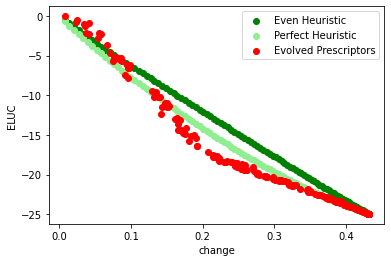

In [22]:
plot_result_pareto((even_changes, even_elucs), (perfect_changes, perfect_elucs), (trained_changes, trained_elucs), figure_dir / "heuristics.png")

In [23]:
def filter_dominating(changes, elucs):
    """
    Gets indices of points that are not dominated by any other point.
    """
    non_dominated_idxs = []
    for i in range(len(changes)):
        dominated = False
        for j in range(len(changes)):
            if i != j and changes[i] >= changes[j] and elucs[i] >= elucs[j]:
                dominated = True
                break
        if not dominated:
            non_dominated_idxs.append(i)
    return non_dominated_idxs


def two_dim_decreasing_neg_hypervolume(x, y, right=1):
    """
    Computes the hypervolume of a 2d pareto.
    We use the sklearn AUC function to find the area between our curve and y = 0,
    then we add the area of the rectangle to the right of the pareto.
    This assumes the y coordinate of the reference point is 0 (which it is in our ELUC case).
    We only consider points under y = 0, adding point 0,0 to the pareto if it is not there.
    :param x: List of x coordinates between [0, 1]
    :param y: List of y coordinates
    :param right: the rightmost edge to compute the rectangle to. Defaults to 1.
    """

    assert len(x) == len(y)
    assert all([0 <= x_i <= 1 for x_i in x])
    assert right >= max(x)

    # Filter out positive y values
    neg_idxs = [i for i in range(len(y)) if y[i] < 0]
    x = [x[i] for i in neg_idxs]
    y = [y[i] for i in neg_idxs]

    # Sort the pareto by x
    sorted_x = sorted(x)
    sorted_y = [y[x.index(sorted_x[i])] for i in range(len(x))]

    # Add point 0,0 if it is not there
    if sorted_x[0] != 0:
        sorted_x = [0] + sorted_x
        sorted_y = [0] + sorted_y

    # Add bottom right point if it is not there
    if sorted_x[-1] != right:
        sorted_x.append(right)
        sorted_y.append(sorted_y[-1])

    # Take the rectangle that is to the top right of each point.
    area = 0
    for i in range(len(sorted_x) - 2, -1, -1):
        area += (sorted_x[i] - sorted_x[i + 1]) * sorted_y[i]

    return area

In [24]:
def plot_result_pareto_hypervolume(even_results, perfect_results, trained_results_sorted, save_path=None):
    even_changes, even_elucs = even_results
    perfect_changes, perfect_elucs = perfect_results
    trained_changes_sorted, trained_elucs_sorted = trained_results_sorted

    plt.scatter([0] + even_changes, [0] + even_elucs, color="green", label="even heuristic forest")
    plt.scatter([0] + perfect_changes, [0] + perfect_elucs, color="lightgreen", label="linreg \"perfect\" heuristic forest")
    plt.scatter([0] + trained_changes_sorted, [0] + trained_elucs_sorted, color="red", label="trained")
    plt.legend()
    plt.xlabel("change")
    plt.ylabel("ELUC")
    plt.xlim([0, 1])

    plt.axhline(0, color="black", linestyle="--")
    plt.axhline(min([min(even_elucs), min(perfect_elucs), min(trained_elucs)]), color="black", linestyle="--")
    plt.axvline(1, color="black", linestyle="--")
    if save_path:
        plt.savefig(save_path, format="png", dpi=300)
    plt.show()

Even hypervolume: 19.68455968958801
Perfect hypervolume: 20.297778217752448
Trained hypervolume: 20.519663724794466


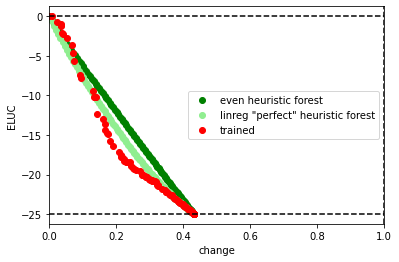

In [25]:
# Filter out points that are dominated by others
idxs = filter_dominating(trained_changes, trained_elucs)
trained_changes_filtered = [trained_changes[i] for i in idxs]
trained_elucs_filtered = [trained_elucs[i] for i in idxs]

print(f"Even hypervolume: {two_dim_decreasing_neg_hypervolume(even_changes, even_elucs)}")
print(f"Perfect hypervolume: {two_dim_decreasing_neg_hypervolume(perfect_changes, perfect_elucs)}")
print(f"Trained hypervolume: {two_dim_decreasing_neg_hypervolume(trained_changes_filtered, trained_elucs_filtered)}")

# Sort filtered points
trained_changes_sorted = sorted(trained_changes_filtered)
trained_elucs_sorted = [trained_elucs_filtered[trained_changes_filtered.index(change)] for change in trained_changes_sorted]

plot_result_pareto_hypervolume((even_changes, even_elucs), 
                                (perfect_changes, perfect_elucs), 
                                (trained_changes_sorted, trained_elucs_sorted))

## Examine Results

In [26]:
def get_idx_close(change, changes):
    diff = [abs(c - change) for c in changes]
    idx = diff.index(min(diff))
    return idx

def plot_selected_points(pct, even_results, perfect_results, trained_results_sorted, save_path=None):
    even_changes, even_elucs = even_results
    perfect_changes, perfect_elucs = perfect_results
    trained_changes_sorted, trained_elucs_sorted = trained_results_sorted

    even_idx = get_idx_close(pct, even_changes)
    perfect_idx = get_idx_close(pct, perfect_changes)
    # Subtract 1 so that we get a dominating point
    trained_idx = get_idx_close(pct, trained_changes_sorted) - 1

    print(f"Even {even_idx}: {even_changes[even_idx]}, {even_elucs[even_idx]}")
    print(f"Perfect {perfect_idx}: {perfect_changes[perfect_idx]}, {perfect_elucs[perfect_idx]}")
    print(f"Trained {trained_idx}: {trained_changes_sorted[trained_idx]}, {trained_elucs_sorted[trained_idx]}")

    plt.scatter([even_changes[even_idx]], [even_elucs[even_idx]], color="green", label="Even Heuristic")
    plt.scatter([perfect_changes[perfect_idx]], [perfect_elucs[perfect_idx]], color="lightgreen", label="Perfect Heuristic")
    plt.scatter([trained_changes_sorted[trained_idx]], [trained_elucs_sorted[trained_idx]], color="red", label="Evolved Prescriptor")
    plt.legend()
    plt.xlabel("change")
    plt.ylabel("ELUC")
    plt.xlim([0, 0.4])
    plt.ylim([-25, 0])
    #plt.title("Average Change vs. ELUC for ~20% change prescriptors")
    if save_path:
        plt.savefig(save_path, format="png", dpi=300)
    plt.show()

    return even_idx, perfect_idx, trained_idx

Even 34: 0.2007746871618255, -12.100224066031352
Perfect 34: 0.2007746871618255, -14.209159078539777
Trained 23: 0.19161835834498558, -16.42003604121471


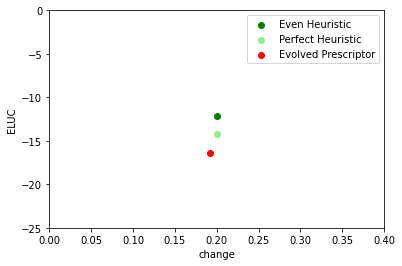

In [27]:
even_idx, perfect_idx, trained_idx = plot_selected_points(0.2, 
                                                          (even_changes, even_elucs), 
                                                          (perfect_changes, perfect_elucs), 
                                                          (trained_changes_sorted, trained_elucs_sorted), 
                                                          figure_dir / "prescmeans.png")

In [28]:
trained_idx_unsort = trained_changes.index(trained_changes_sorted[trained_idx])
trained_result = trained_prescribe_and_predict(encoded_context_df, all_gen_pareto_df["id"].unique()[trained_idx_unsort], dataset.encoder, dummy_prescriptor)
even_result = heuristic_prescribe_and_predict(context_df, dummy_prescriptor, even_prescribe, pcts[even_idx], best_col)
perfect_result = heuristic_prescribe_and_predict(context_df, dummy_prescriptor, perfect_prescribe, pcts[perfect_idx], coefs)

trained_result = trained_result.set_index(even_result.index)

757/757 [==============================] - 3s 4ms/step


In [29]:
def plot_expanded(even_sample, perfect_sample, trained_sample, save_path=None):
    # Evolved first so that it is on the bottom
    plt.scatter(trained_sample["change"], trained_sample["ELUC"], color="red", label="Evolved Prescriptor")
    plt.scatter(even_sample["change"], even_sample["ELUC"], color="green", label="Even Heuristic")
    plt.scatter(perfect_sample["change"], perfect_sample["ELUC"], color="lightgreen", label="Perfect Heuristic")
    # Rearrange legend (from stackoverflow)
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [1, 2, 0]
    plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order])
    plt.xlabel("change")
    plt.ylabel("ELUC")
    #plt.title("Expanded view of ~20% change prescriptors (subsampled)")
    if save_path:
        plt.savefig(save_path, format="png", dpi=300)
    plt.show()

Heuristic threshold: 0.3500000439438788


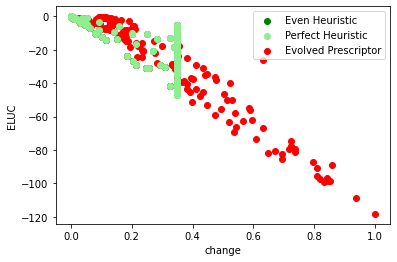

In [55]:
print(f"Heuristic threshold: {even_result['change'].max()}")

# Changed random seed to get a dominated point in the diffs
trained_sample = trained_result.sample(frac=0.01, random_state=43)
even_sample = even_result.loc[trained_sample.index]
perfect_sample = perfect_result.loc[trained_sample.index]
plot_expanded(even_sample, perfect_sample, trained_sample, figure_dir / "prescexpanded.png")

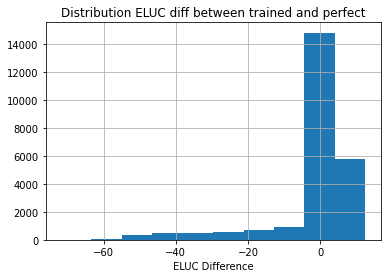

In [56]:
eluc_diff = trained_result["ELUC"] - perfect_result["ELUC"]
plt.title("Distribution ELUC diff between trained and perfect")
plt.xlabel("ELUC Difference")
plt.hist(eluc_diff)
plt.grid()
plt.show()

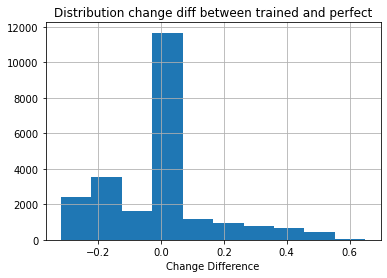

In [57]:
change_diff = trained_result["change"] - perfect_result["change"]
plt.title("Distribution change diff between trained and perfect")
plt.xlabel("Change Difference")
plt.hist(change_diff)
plt.grid()
plt.show()

In [58]:
def plot_diffs(perfect_sample, trained_sample, save_path=None):
    diff_df = pd.DataFrame()
    diff_df["change"] = trained_sample["change"] - perfect_sample["change"]
    diff_df["ELUC"] = trained_sample["ELUC"] - perfect_sample["ELUC"]
    # diff_df["change"] = trained_result["change"] - perfect_result["change"]
    # diff_df["ELUC"] = trained_result["ELUC"] - perfect_result["ELUC"]
    dom = diff_df[(diff_df["change"] < 0) & (diff_df["ELUC"] < 0)]
    other_dom = diff_df[(diff_df["change"] > 0) & (diff_df["ELUC"] > 0)]
    plt.scatter(diff_df["change"], diff_df["ELUC"], label="No domination")
    plt.scatter(other_dom["change"], other_dom["ELUC"], color="lightgreen", label="Perfect Heuristic dominates")
    plt.scatter(dom["change"], dom["ELUC"], color="red", label="Evolved Prescriptor dominates")
    plt.axhline(0, color="black", linestyle="--")
    plt.axvline(0, color="black", linestyle="--")
    plt.xlabel("Change Difference")
    plt.ylabel("ELUC Difference")
    #plt.title("Change Diff vs. ELUC Diff Between Trained and Perfect (subsampled)")
    plt.legend()
    if save_path:
        plt.savefig(save_path, format="png", dpi=300)
    plt.show()

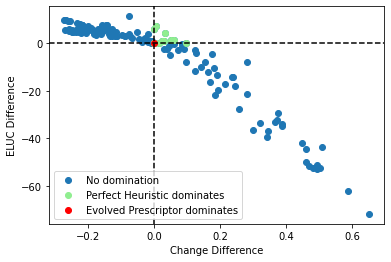

In [59]:
plot_diffs(perfect_sample, trained_sample, figure_dir / "prescdiffs.png")

In [69]:
low_change_idx = change_diff[(change_diff < 0)].index
low_change_eluc_diff = eluc_diff[low_change_idx]
low_change_neg_eluc_diff = low_change_eluc_diff[low_change_eluc_diff < 0]
print(f"Number less change better ELUC: {len(low_change_neg_eluc_diff)} ({len(low_change_neg_eluc_diff) / len(change_diff) * 100}%)")
min_idx = low_change_neg_eluc_diff.sort_values().index[0]
print(f"Max difference in ELUC with less change: {eluc_diff[min_idx]}")

print("Changes")
print(even_result.loc[min_idx]["change"], perfect_result.loc[min_idx]["change"], trained_result.loc[min_idx]["change"])
print()
print("ELUCs")
print(even_result.loc[min_idx]["ELUC"], perfect_result.loc[min_idx]["ELUC"], trained_result.loc[min_idx]["ELUC"])
print()
print([f"{col}: {even_result.loc[min_idx][col]}" for col in constants.CAO_MAPPING["context"]])
print("Prescribed:")
print([f"{col}: {even_result.loc[min_idx][col]}" for col in constants.DIFF_RECO_COLS])
print([f"{col}: {perfect_result.loc[min_idx][col]}" for col in constants.DIFF_RECO_COLS])
print([f"{col}: {trained_result.loc[min_idx][col]}" for col in constants.DIFF_RECO_COLS])


Number less change better ELUC: 23 (0.09502561560072716%)
Max difference in ELUC with less change: -0.19959735870361328
Changes
0.35000000073796705 0.35000000073796705 0.3332486968858965

ELUCs
-6.7735514640808105 -6.147274971008301 -6.346872329711914

['crop: 0.00019714348309207708', 'pastr: 0.0', 'primf: 0.0', 'primn: 0.09017181396484375', 'range: 0.2005922496318817', 'secdf: 0.0', 'secdn: 0.2404637336730957', 'urban: 0.0', 'cell_area: 77122.2734375', 'lat: 3.625', 'lon: 35.875', 'time: 2021.0']
Prescribed:
['crop_diff: -8.310068555122573e-05', 'pastr_diff: 0.0', 'range_diff: -0.08455442299802755', 'secdf_diff: 0.18599872926351962', 'secdn_diff: -0.10136120557994083']
['crop_diff: -0.00019714348309207708', 'pastr_diff: 0.0', 'range_diff: -0.18580158578042755', 'secdf_diff: 0.18599872926351962', 'secdn_diff: 0.0']
['crop_diff: -0.00019714348309207708', 'pastr_diff: 0.0', 'range_diff: -0.002269297761808786', 'secdf_diff: 0.17709666862516876', 'secdn_diff: -0.17463022850076537']


In [61]:
# How many are greater than the MAE of predictor model
signif = low_change_neg_eluc_diff[abs(low_change_neg_eluc_diff) > 0.05]
print(f"Number of points where trained prescriptor prescribes less change than perfect heuristic AND produces better ELUC by more than predictor model MAE: {len(signif)}")
print(f"Average difference in change for these points: {change_diff.loc[signif.index].mean()}")
print(f"Average difference in ELUC for these points: {signif.mean()}")

Number of points where trained prescriptor prescribes less change than perfect heuristic AND produces better ELUC by more than predictor model MAE: 1
Average difference in change for these points: -0.016751303852070576
Average difference in ELUC for these points: -0.19959735870361328


In [62]:
def plot_avg_prescription(even_result, perfect_result, trained_result, save_path=None):
    even_total_diffs = even_result[constants.DIFF_RECO_COLS].sum(axis=0) / len(even_result)
    perfect_total_diffs = perfect_result[constants.DIFF_RECO_COLS].sum(axis=0) / len(perfect_result)
    trained_total_diffs = trained_result[constants.DIFF_RECO_COLS].sum(axis=0) / len(trained_result)

    xticks = np.arange(len(constants.DIFF_RECO_COLS))

    plt.bar(xticks-0.3, even_total_diffs, 0.3, label="Even Heuristic", color="green")
    plt.bar(xticks, perfect_total_diffs, 0.3, label="Perfect Heuristic", color="lightgreen")
    plt.bar(xticks+0.3, trained_total_diffs, 0.3, label="Evolved Prescriptor", color="red")
    plt.xticks(xticks, constants.DIFF_RECO_COLS, rotation=90)
    plt.legend()
    plt.grid()
    #plt.title("Average land use change for each prescriptor")
    fig = plt.gcf()
    fig.set_tight_layout(True)
    if save_path:
        plt.savefig(save_path, format="png", dpi=300)
    plt.show()

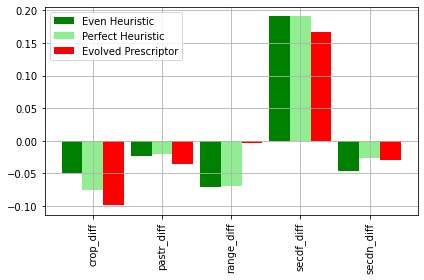

In [63]:
plot_avg_prescription(even_result, perfect_result, trained_result, figure_dir / "prescbar.png")

#### See what features cause more change

[0.9034329723590094, 0.5270310236124349, -0.3437839547324, -0.28288466448177985, -0.01656602250485311, -0.12650073998417496, 0.14500440468048173, 0.15880564682906545, 0.3730995714791435, -0.3173523153618355, -0.26850716728343194, 0.015444815120229402]


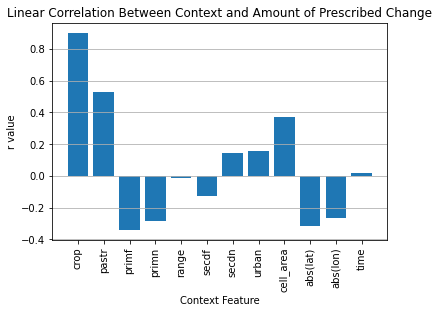

In [64]:
rs = []
for col in constants.LAND_USE_COLS + constants.NONLAND_FEATURES:
    feat = trained_result[col]
    if col == "lat" or col == "lon":
        feat = abs(feat)
    rs.append(feat.corr(trained_result["change"]))
print(rs)

labels = constants.LAND_USE_COLS + constants.NONLAND_FEATURES
labels[labels.index("lat")] = "abs(lat)"
labels[labels.index("lon")] = "abs(lon)"
plt.bar(labels, rs)
plt.xticks(rotation=90)
plt.xlabel("Context Feature")
plt.ylabel("r value")
plt.title("Linear Correlation Between Context and Amount of Prescribed Change")
plt.grid(axis="y")
#plt.savefig("figures/corr.png", format="png", dpi=300)
plt.show()

In [66]:
def plot_context_change(feature, save):
    plt.scatter(trained_sample[feature], trained_sample["change"])
    plt.title(f"Context {feature} vs. Amount of Prescribed Change")
    plt.ylabel("Change")
    plt.xlabel(feature)
    if feature in constants.LAND_USE_COLS:
        plt.plot([0, 1], [0, 1], color="black", linestyle="--", label="y=x")
        plt.plot([0, 1], [1, 0], color="red", linestyle="--", label="y=1-x")
        plt.legend()
    if save:
        plt.savefig(f"figures/{feature}change.png", format="png", dpi=300)
    plt.show()

In [67]:
# for feature in constants.LAND_USE_COLS + constants.NONLAND_FEATURES:
#     plot_context_change(feature, False)

## Compare to Global Warming

In [68]:
pcts = [0.01, 0.05, 0.1, 0.2, 0.5, 1]
total_emissions = []
total_changes = []
for pct in tqdm(pcts):
    result_df = heuristic_prescribe_and_predict(dataset.test_df.loc[2021][constants.CAO_MAPPING["context"]], dummy_prescriptor, perfect_prescribe, pct, linreg.coef_)
    result_df["total_emissions"] = result_df["ELUC"] * result_df["cell_area"]
    result_df["total_change"] = result_df["change"] * result_df["cell_area"]
    total_emissions.append(result_df["total_emissions"].sum())
    total_changes.append(result_df["total_change"].sum() / result_df["cell_area"].sum())

  0%|          | 0/6 [00:08<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# Weight of CO2 vs. C
conversion = 3.664
# Remaining Carbon budget
rcb = 250
# Yearly net emissions
yearly = 20

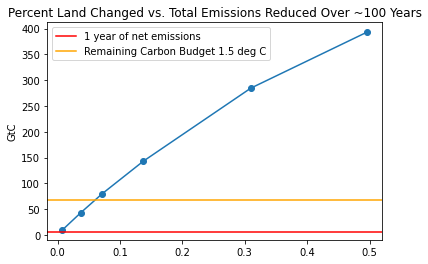

In [ ]:
fig = plt.figure(facecolor="white")
plt.plot(total_changes, [-1 * t / 1e9 for t in total_emissions], marker="o")
plt.axhline(y=yearly / conversion, color='r', label="1 year of net emissions")
plt.axhline(y=rcb / conversion, color='orange', label="Remaining Carbon Budget 1.5 deg C")
plt.legend()
plt.title("Percent Land Changed vs. Total Emissions Reduced Over ~100 Years")
plt.ylabel("GtC")
plt.show()

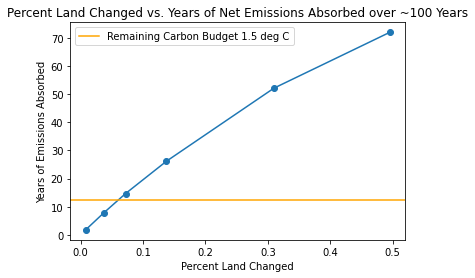

In [ ]:
fig = plt.figure(facecolor="white")
plt.plot(total_changes, [t / (-2e10 / conversion) for t in total_emissions], marker="o")
plt.axhline(y=rcb / yearly, color='orange', label="Remaining Carbon Budget 1.5 deg C")
plt.title("Percent Land Changed vs. Years of Net Emissions Absorbed over ~100 Years")
plt.xlabel("Percent Land Changed")
plt.ylabel("Years of Emissions Absorbed")
plt.legend()
plt.show()